In [1]:
import numpy as np
import os
import pandas as pd

from feature_engineering import (
    add_return_data,
    add_simple_moving_average,
    generate_image_data,
)
from pathlib import Path
from PIL import Image
from tqdm.notebook import tqdm


### Image Config

In [2]:
def get_image_config(days: int):
    '''
    return: image_height, volume_image_height, gap_height
    '''
    # 5d - 32x15 
    if days == 5:
        return 32, 6, 2
    
    # 20d - 64x60
    if days == 20:
        return 64, 13, 1
    
    # 60d - 96x180
    if days == 60:
        return 96, 19, 1
    
    # 250d - 256x756
    if days == 250:
        return 256, 51, 1
    
    raise Exception("Image Size is not configured")

### Data Processing

In [3]:
# add return_date and return_value and moving average data
def calculate_df(df: pd.DataFrame) -> pd.DataFrame:
    df = add_return_data(df, 5) # add return_5
    df = add_return_data(df, 20) # add return_20
    df = add_return_data(df, 60) # add return_60
    df = add_simple_moving_average(df, 50) # add ma_50
    df = add_simple_moving_average(df, 100) # add ma_100
    df = add_simple_moving_average(df, 200) # add ma_200
    return df

In [4]:
# generate images dataset with labels
def add_features(
        dataset: pd.DataFrame, # expect to load the whole dataset (clean data, no null)
        lookback_days: int, # how many days are included in the image (eg: 5, 20, 60, 252)
        return_days: int, # which return value is used for the label (5 or 20 or 60 only)
        ohlc_image_height: int,
        volume_image_height: int, # put 0 if we don't want volume barchart
        gap_height: int, # put 0 if we don't want volume barchart
        include_ma_50d: bool,
        include_ma_100d: bool,
        include_ma_200d: bool,
        label_negitive_margin: float,
        label_positive_margin: float,
        save_image: bool, # True: will generate all the images and save in the path folder
        save_meta: bool, # True: will save the meta.csv in the path folder
        ticker: str,
        root_path: str = None,
    ):
    if return_days not in [5, 20, 60]:
        raise Exception(f'Invalud return_days: {return_days}')
    meta = {
        'id': [],
        'img_data': [],
        'date': [],
        'return_value': [],
        'label': []
    }

    # a simple function to map return value to label class
    def label_funt(value: float):
        if value < label_negitive_margin:
            return 0
        if value < 0:
            return 1
        if value < label_positive_margin:
            return 2
        return 3
    
    # remove rows without ma data if we are including the curve
    if include_ma_50d:
        dataset = dataset.dropna(subset=['ma_50d'])
    if include_ma_100d:
        dataset = dataset.dropna(subset=['ma_100d'])
    if include_ma_200d:
        dataset = dataset.dropna(subset=['ma_200d'])
    
    for i in range(len(dataset)):
        subset = dataset[i:i+lookback_days] # retrieve lookback data
        # break if the subset does not have enough data (almost the end of the raw data)
        if len(subset) != lookback_days:
            print(f'End at i: {i} - len(subset) != lookback_days')
            break
        if np.isnan(subset.iloc[-1][f'return_{return_days}_value']):
            print(f'End at i: {i} - return value nan')
            break
        imgData = generate_image_data(
            subset,
            ohlc_image_height,
            volume_image_height,
            gap_height,
            include_ma_50d,
            include_ma_100d,
            include_ma_200d,
        )
        return_value = subset.iloc[-1][f'return_{return_days}_value']
        label = label_funt(float(return_value))
        output_file_name = f'{ticker}_{i}'
        meta['id'].append(output_file_name)
        meta['img_data'].append(imgData)
        meta['date'].append(subset.iloc[-1][f'date'])
        meta['return_value'].append(return_value)
        meta['label'].append(label)
        
        if save_image:
            img = Image.fromarray(imgData)
            img.save(os.path.join(root_path, str(label), f'{output_file_name}.png'))
        
    meta_df = pd.DataFrame(meta)
    if save_meta:
        meta_file_path = os.path.join(Path(root_path).parent.absolute(), 'meta.csv')
        file_exists = os.path.exists(meta_file_path)
        mode = 'a' if file_exists else 'w'
        meta_df.drop(columns=['img_data']).to_csv(meta_file_path, mode=mode, header=not file_exists)
    return meta_df

### Demo

In [5]:
dataPath='../../../dataset/market_data/output/nikkei_225/CONSTITUENTS_DAILY_9984.T.csv'
df = pd.read_csv(dataPath, parse_dates=['date'])
df = df.dropna(how='any').sort_values(by=['date'], ascending=True) # remove row with null
df = calculate_df(df)

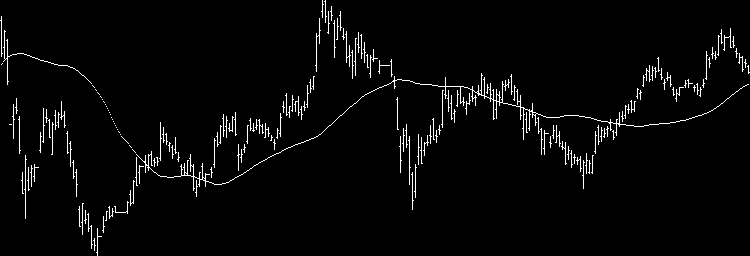

In [6]:
# example: 50d-ma + ohlc in 250 days
subset = df[1002:1252]
imgData = generate_image_data(subset, get_image_config(250)[0], 0, 0, True, False, False)
img = Image.fromarray(imgData)
display(img)

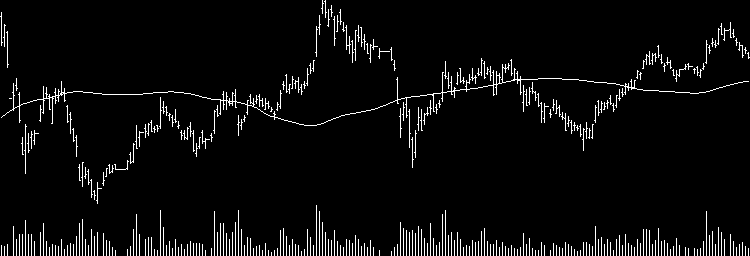

In [7]:
# example: 100d-ma + ohlc + volume in 250 days
subset = df[1002:1252]
image_height, volume_image_height, gap_height = get_image_config(250)
imgData = generate_image_data(
    subset,
    image_height - volume_image_height - gap_height,
    volume_image_height,
    gap_height,
    False,
    True,
    False
)
img = Image.fromarray(imgData)
display(img)

In [ ]:
# create demo images and metas 
dataset_raw = df[0:4000]
image_height, volume_image_height, gap_height = get_image_config(20)
dataset = add_features(
    dataset_raw,
    20,
    20,
    image_height - volume_image_height - gap_height,
    volume_image_height,
    gap_height,
    True,
    False,
    False,
    -0.5,
    0.5,
    False,
    False,
    '9984_T'
)
dataset.sample(5)

### Graph Generator

In [8]:
# TODO: create a config file to define the parameter
def generate_ohlc_graph(market: str, lookback_days: int, forecast_days: int):
    #input
    source_root_path = os.path.abspath(f'../../../dataset/market_data/output/{market}')
    if not os.path.exists(source_root_path):
        raise RuntimeError(f'Path {source_root_path} does not exist')
    
    #output
    output_root_path = os.path.abspath(f'../../../dataset/ohlc_graphs/{market}/{lookback_days}d')
    for label in range(4):
        Path(os.path.join(output_root_path, str(label))).mkdir(parents=True, exist_ok=True)
    
    image_height, volume_image_height, gap_height = get_image_config(lookback_days)
    for source_file in tqdm(os.listdir(source_root_path)):
        if source_file.startswith('CONSTITUENTS'):
            ticker = source_file.replace('CONSTITUENTS_DAILY_', '').replace('.csv', '').replace('.', '_')
            source_file_path = os.path.join(source_root_path, source_file)
            print(f'Read raw data from {source_file_path}')
            source_df = pd.read_csv(source_file_path, parse_dates=['date'])\
                .dropna(how='any')\
                .sort_values(by=['date'], ascending=True)
            add_features(
                calculate_df(source_df), 
                lookback_days,
                forecast_days,
                image_height - volume_image_height - gap_height,
                volume_image_height,
                gap_height,
                include_ma_50d=False,
                include_ma_100d=True,
                include_ma_200d=False,
                label_negitive_margin=-0.1,
                label_positive_margin=0.1,
                save_image=True,
                save_meta=True,
                ticker=ticker,
                root_path=output_root_path
            )
        

In [9]:
generate_ohlc_graph('nikkei_mid_small_cap', 20, 20)

  0%|          | 0/196 [00:00<?, ?it/s]

Read raw data from C:\Users\User\OneDrive\OneDrive - The University of Hong Kong - Connect\Documents\HKU MScCS\COMP7705 MSc(CompSc) Project\dataset\market_data\output\nikkei_mid_small_cap\CONSTITUENTS_DAILY_1407.T.csv
End at i: 4755 - return value nan
Read raw data from C:\Users\User\OneDrive\OneDrive - The University of Hong Kong - Connect\Documents\HKU MScCS\COMP7705 MSc(CompSc) Project\dataset\market_data\output\nikkei_mid_small_cap\CONSTITUENTS_DAILY_1419.T.csv
End at i: 2574 - return value nan
Read raw data from C:\Users\User\OneDrive\OneDrive - The University of Hong Kong - Connect\Documents\HKU MScCS\COMP7705 MSc(CompSc) Project\dataset\market_data\output\nikkei_mid_small_cap\CONSTITUENTS_DAILY_1518.T.csv
End at i: 5663 - return value nan
Read raw data from C:\Users\User\OneDrive\OneDrive - The University of Hong Kong - Connect\Documents\HKU MScCS\COMP7705 MSc(CompSc) Project\dataset\market_data\output\nikkei_mid_small_cap\CONSTITUENTS_DAILY_1879.T.csv
End at i: 5660 - return va

End at i: 5663 - return value nan
Read raw data from C:\Users\User\OneDrive\OneDrive - The University of Hong Kong - Connect\Documents\HKU MScCS\COMP7705 MSc(CompSc) Project\dataset\market_data\output\nikkei_mid_small_cap\CONSTITUENTS_DAILY_3134.T.csv
End at i: 2067 - return value nan
Read raw data from C:\Users\User\OneDrive\OneDrive - The University of Hong Kong - Connect\Documents\HKU MScCS\COMP7705 MSc(CompSc) Project\dataset\market_data\output\nikkei_mid_small_cap\CONSTITUENTS_DAILY_3150.T.csv
End at i: 3561 - return value nan
Read raw data from C:\Users\User\OneDrive\OneDrive - The University of Hong Kong - Connect\Documents\HKU MScCS\COMP7705 MSc(CompSc) Project\dataset\market_data\output\nikkei_mid_small_cap\CONSTITUENTS_DAILY_3167.T.csv
End at i: 5660 - return value nan
Read raw data from C:\Users\User\OneDrive\OneDrive - The University of Hong Kong - Connect\Documents\HKU MScCS\COMP7705 MSc(CompSc) Project\dataset\market_data\output\nikkei_mid_small_cap\CONSTITUENTS_DAILY_317

End at i: 1593 - return value nan
Read raw data from C:\Users\User\OneDrive\OneDrive - The University of Hong Kong - Connect\Documents\HKU MScCS\COMP7705 MSc(CompSc) Project\dataset\market_data\output\nikkei_mid_small_cap\CONSTITUENTS_DAILY_3983.T.csv
End at i: 1596 - return value nan
Read raw data from C:\Users\User\OneDrive\OneDrive - The University of Hong Kong - Connect\Documents\HKU MScCS\COMP7705 MSc(CompSc) Project\dataset\market_data\output\nikkei_mid_small_cap\CONSTITUENTS_DAILY_3991.T.csv
End at i: 1474 - return value nan
Read raw data from C:\Users\User\OneDrive\OneDrive - The University of Hong Kong - Connect\Documents\HKU MScCS\COMP7705 MSc(CompSc) Project\dataset\market_data\output\nikkei_mid_small_cap\CONSTITUENTS_DAILY_4047.T.csv
End at i: 5663 - return value nan
Read raw data from C:\Users\User\OneDrive\OneDrive - The University of Hong Kong - Connect\Documents\HKU MScCS\COMP7705 MSc(CompSc) Project\dataset\market_data\output\nikkei_mid_small_cap\CONSTITUENTS_DAILY_418

End at i: 2114 - return value nan
Read raw data from C:\Users\User\OneDrive\OneDrive - The University of Hong Kong - Connect\Documents\HKU MScCS\COMP7705 MSc(CompSc) Project\dataset\market_data\output\nikkei_mid_small_cap\CONSTITUENTS_DAILY_6050.T.csv
End at i: 3143 - return value nan
Read raw data from C:\Users\User\OneDrive\OneDrive - The University of Hong Kong - Connect\Documents\HKU MScCS\COMP7705 MSc(CompSc) Project\dataset\market_data\output\nikkei_mid_small_cap\CONSTITUENTS_DAILY_6058.T.csv
End at i: 2820 - return value nan
Read raw data from C:\Users\User\OneDrive\OneDrive - The University of Hong Kong - Connect\Documents\HKU MScCS\COMP7705 MSc(CompSc) Project\dataset\market_data\output\nikkei_mid_small_cap\CONSTITUENTS_DAILY_6062.T.csv
End at i: 2797 - return value nan
Read raw data from C:\Users\User\OneDrive\OneDrive - The University of Hong Kong - Connect\Documents\HKU MScCS\COMP7705 MSc(CompSc) Project\dataset\market_data\output\nikkei_mid_small_cap\CONSTITUENTS_DAILY_607

End at i: 5679 - return value nan
Read raw data from C:\Users\User\OneDrive\OneDrive - The University of Hong Kong - Connect\Documents\HKU MScCS\COMP7705 MSc(CompSc) Project\dataset\market_data\output\nikkei_mid_small_cap\CONSTITUENTS_DAILY_6871.T.csv
End at i: 5922 - return value nan
Read raw data from C:\Users\User\OneDrive\OneDrive - The University of Hong Kong - Connect\Documents\HKU MScCS\COMP7705 MSc(CompSc) Project\dataset\market_data\output\nikkei_mid_small_cap\CONSTITUENTS_DAILY_6875.T.csv
End at i: 5660 - return value nan
Read raw data from C:\Users\User\OneDrive\OneDrive - The University of Hong Kong - Connect\Documents\HKU MScCS\COMP7705 MSc(CompSc) Project\dataset\market_data\output\nikkei_mid_small_cap\CONSTITUENTS_DAILY_6941.T.csv
End at i: 5660 - return value nan
Read raw data from C:\Users\User\OneDrive\OneDrive - The University of Hong Kong - Connect\Documents\HKU MScCS\COMP7705 MSc(CompSc) Project\dataset\market_data\output\nikkei_mid_small_cap\CONSTITUENTS_DAILY_704

End at i: 5663 - return value nan
Read raw data from C:\Users\User\OneDrive\OneDrive - The University of Hong Kong - Connect\Documents\HKU MScCS\COMP7705 MSc(CompSc) Project\dataset\market_data\output\nikkei_mid_small_cap\CONSTITUENTS_DAILY_8154.T.csv
End at i: 5663 - return value nan
Read raw data from C:\Users\User\OneDrive\OneDrive - The University of Hong Kong - Connect\Documents\HKU MScCS\COMP7705 MSc(CompSc) Project\dataset\market_data\output\nikkei_mid_small_cap\CONSTITUENTS_DAILY_8595.T.csv
End at i: 5643 - return value nan
Read raw data from C:\Users\User\OneDrive\OneDrive - The University of Hong Kong - Connect\Documents\HKU MScCS\COMP7705 MSc(CompSc) Project\dataset\market_data\output\nikkei_mid_small_cap\CONSTITUENTS_DAILY_8698.T.csv
End at i: 4728 - return value nan
Read raw data from C:\Users\User\OneDrive\OneDrive - The University of Hong Kong - Connect\Documents\HKU MScCS\COMP7705 MSc(CompSc) Project\dataset\market_data\output\nikkei_mid_small_cap\CONSTITUENTS_DAILY_870